In [1]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter, laplace

In [2]:
# Canny Edge Detection
def canny_edge_detection(image, low_threshold=100, high_threshold=200):

    image_uint8 = np.uint8(image * 255)
    edges = cv2.Canny(image_uint8, low_threshold, high_threshold)
    return edges

In [3]:
from scipy.ndimage import binary_dilation
import zstandard as zstd
from skimage import io, color

def compress_image(image, edge_mask, q=4, d=1):
    """
    Encodes pixel values along edges and boundary pixels with debugging.
    """
    edge_mask = edge_mask.astype(bool)

    # plt.close('all')
    # plt.imshow(edge_mask, cmap='gray')
    # plt.title("Edge_mask")
    # plt.show()

    # get image dimensions
    h, w = image.shape

    # quantize
    max_val = 255
    quantized_image = (image / max_val * (2**q - 1))

    # debug quantized image
    # plt.imshow(quantized_image, cmap='gray')
    # plt.title("Quantized Image")
    # plt.colorbar()
    # plt.show()

    dilated_edges = binary_dilation(edge_mask)
    side_pixels = dilated_edges & ~edge_mask  # Pixels adjacent to edges

    # Debug dilated edges
    # print("Dilated Edges:")
    # plt.imshow(dilated_edges, cmap='gray')
    # plt.show()

    # print("Side Pixels:")
    # plt.imshow(side_pixels, cmap='gray')
    # plt.show()

    # Store boundary pixels
    boundary_mask = np.zeros_like(image, dtype=bool)
    boundary_mask[0, :] = boundary_mask[-1, :] = True
    boundary_mask[:, 0] = boundary_mask[:, -1] = True

    # Combine masks for pixels to be stored
    store_mask = side_pixels | boundary_mask

    # Debug store mask
    # print("Store Mask:")
    # plt.imshow(store_mask, cmap='gray')
    # plt.show()

    # extract values based on sampling distance d
    indices = np.argwhere(store_mask)
    # print(f"Number of Indices Before Sampling: {len(indices)}")
    sampled_indices = indices[::d]  # subsample
    # print(f"Number of Indices After Sampling: {len(sampled_indices)}")

    sampled_data = [(idx[0], idx[1], quantized_image[tuple(idx)]) for idx in sampled_indices]
    # print(f"Sampled Values (First 10): {sampled_data[:10]}")

    cctx = zstd.ZstdCompressor(level=3)
    compressed_data = cctx.compress(pickle.dumps(sampled_data))

    return compressed_data

In [4]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import laplace
import matplotlib.pyplot as plt

def decompress_image(sampled_data, edge_mask, image_shape, image_dtype, q=4, d=1, diffusion_iters=10000, tol=1e-5):

    # plt.ion()  # Enable interactive mode

    # Reconstruct pixel values
    max_val = 255
    quant_step = max_val / (2**q - 1)

    # Initialize the image
    reconstructed_image = np.zeros(image_shape)
    sampled_positions = []
    pixel_values = []

    # Place quantized values at edge positions
    for row, col, quantized_value in sampled_data:
        reconstructed_image[row, col] = quantized_value * quant_step  # Dequantize
        sampled_positions.append((row, col))
        pixel_values.append(quantized_value * quant_step)

    # Debug: Visualize initial placement
    # plt.close('all')
    # plt.imshow(reconstructed_image, cmap='gray')
    # plt.title("After Placing Edge-Adjacent Pixels")
    # plt.colorbar()
    # plt.show()

    # Interpolate along edges
    for edge_idx in range(len(sampled_positions) - 1):
        start, end = sampled_positions[edge_idx], sampled_positions[edge_idx + 1]
        line_coords = np.linspace(start, end, num=d, endpoint=False, axis=0)
        interp_values = np.linspace(pixel_values[edge_idx], pixel_values[edge_idx + 1], len(line_coords))
        for coord, interp_value in zip(line_coords, interp_values):
            reconstructed_image[tuple(map(int, coord))] = interp_value

    dilated_edge_mask = binary_dilation(edge_mask)  # Dilate the edge mask
    dilated_edge_mask[0, :] = dilated_edge_mask[-1, :] = True
    dilated_edge_mask[:, 0] = dilated_edge_mask[:, -1] = True
    reconstructed_image = reconstructed_image * dilated_edge_mask  # Bitwise AND

    # Debug: Visualize after interpolation
    # plt.close('all')
    # plt.imshow(reconstructed_image, cmap='gray')
    # plt.title("After Edge Interpolation")
    # plt.colorbar()
    # plt.show()

    # Missing data mask
    missing_mask = (reconstructed_image == 0)

    # plt.close('all')
    # plt.imshow(missing_mask, cmap='gray')
    # plt.title("Missing Data Mask")
    # plt.colorbar()
    # plt.show()

    dt = 0.1
    for i in range(diffusion_iters):
      previous_image = reconstructed_image.copy()
      diffusion_step = laplace(previous_image)
      reconstructed_image[missing_mask] += dt * diffusion_step[missing_mask]
      diff = np.abs(reconstructed_image - previous_image).max()
      if diff < tol:
          print(f"Converged after {i} iterations with max diff {diff}")
          break

    # Clip values to valid range
    reconstructed_image = np.clip(reconstructed_image, 0, 255)

    # Debug: Final visualization
    # plt.close('all')
    # plt.imshow(reconstructed_image, cmap='gray')
    # plt.title("Reconstructed Image")
    # plt.colorbar()
    # plt.show()

    return reconstructed_image

In [5]:
import pickle

def rle_encode(data):
    """Encodes data using Run-Length Encoding (RLE)."""

    data = data.flatten()
    encoded = []
    count = 1
    for i in range(1, len(data)):
        if data[i] == data[i - 1]:
            count += 1
        else:
            encoded.extend([data[i - 1], count])
            count = 1
    encoded.extend([data[-1], count])

    encoded_bytes = pickle.dumps(encoded)

    return encoded_bytes

def rle_decode(encoded):
    """Decodes RLE-encoded data."""
    decoded = []
    for i in range(0, len(encoded), 2):
        value, count = encoded[i], encoded[i + 1]
        decoded.extend([value] * count)
    return decoded

In [6]:
def create_compressed_file(image, edge_mask, image_dtype, q, d, filename="compressed_image.bin"):
    """Creates the final compressed file."""

    edge_mask_encode = rle_encode(edge_mask)

    h, w, c = image.shape

    paq_data = []  # Initialize paq_data as a list
    paq_data_len = [] # Intialize paq_data_len as a list

    for i in range(c):
        compressed_channel_data = compress_image(image[:, :, i], edge_mask, q, d)
        paq_data.append(compressed_channel_data)
        paq_data_len.append(len(compressed_channel_data)) # Store the length

    # Header information (example, modify as needed)
    header = {
        "img_size": image.shape,
        "q": q,
        "d": d,
        "edge_mask_len": len(edge_mask_encode),
        "paq_data_len": paq_data_len, # Add paq_data_len to the header
        "channels": c,  # Or 3 for color images
        "img_datatype": image_dtype
    }

    # Combine data and write to file
    with open(filename, "wb") as f:
        f.write(pickle.dumps(header))  # Write header
        f.write(edge_mask_encode)  # Write JBIG data
        for channel_data in paq_data:
            f.write(channel_data)  # Write PAQ data for each channel

def decompress_file(filename="compressed_image.bin"):

    """Decompresses the compressed file and reconstructs the image."""

    with open(filename, "rb") as f:
        # read Header Information
        header = pickle.load(f)
        image_shape = header["img_size"]
        q = header["q"]
        d = header["d"]
        edge_mask_len = header["edge_mask_len"]
        channels = header["channels"]
        paq_data_len = header["paq_data_len"]
        image_dtype = header["img_datatype"]

        # read Mask and Decompress Edge Mask
        edge_mask_data = f.read(edge_mask_len)
        decoded_data = pickle.loads(edge_mask_data)
        decoded = rle_decode(decoded_data)
        edge_mask = np.array(decoded).reshape(image_shape[:2])

        reconstructed_image = np.zeros(image_shape, dtype=image_dtype)
        #current_position = f.tell()

        for i in range(channels):
            #f.seek(current_position)
            compressed_channel_data = f.read(paq_data_len[i])
            dctx = zstd.ZstdDecompressor()
            sampled_data = pickle.loads(dctx.decompress(compressed_channel_data))

            # call decompress_image
            reconstructed_image[:, :, i] = decompress_image(sampled_data, edge_mask, image_shape[:2], image_dtype, q, d)
            #current_position += paq_data_len[i]

        return reconstructed_image

In [7]:
def compress_and_decompress_image(image, image_dtype, q=4, d=2, filename="compressed_image.bin"):
    """
    Compresses and decompresses an image using Canny edge detection, JBIG, and
    a chosen compression library (zstd in this example).

    Args:
        image: The input image.
        q: Quantization parameter.
        d: Sampling distance.
        filename: The filename for the compressed image.

    Returns:
        The reconstructed image.
    """
    image1 = image / 255.0  # Normalize image

    edges_canny = canny_edge_detection(image1, low_threshold=100, high_threshold=200)

    create_compressed_file(image, edges_canny, image_dtype, q, d)

    reconstructed_image = decompress_file(filename)

    return reconstructed_image

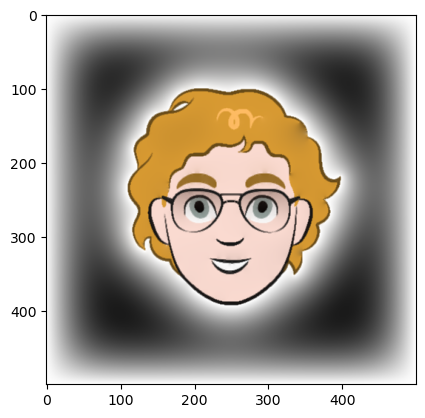

In [8]:
# To compress and decompress an image
image = cv2.imread('./dataset/cartoon/cs1048486361028912.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
#print(image.shape)
image_dtype = image.dtype
#print(image_dtype)

reconstructed_image = compress_and_decompress_image(image, image_dtype, 4, 1)
plt.imshow(reconstructed_image)
plt.show()